<a href="https://www.kaggle.com/code/ravaghi/fine-tuning-norbert3-for-sentiment-analysis?scriptVersionId=165926407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q transformers datasets evaluate accelerate

In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    roc_curve
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

plt.style.use("ggplot")
sns.set_palette("Set2")

2024-03-07 20:46:54.838124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 20:46:54.838230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 20:46:54.980753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Defining configs

In [3]:
MODEL_NAME = "ltg/norbert3-xs"
MAX_EPOCHS = 100
BATCH_SIZE = 64
MAX_TOKEN_LENGTH = 512

# Loading and processing data

In [4]:
dataset = pd.read_csv("/kaggle/input/norwegian-review-corpus/norec.csv")

dataset["label"] = dataset["rating"].apply(lambda rating: 1 if rating > 3 else 0)

train_df = dataset[dataset["split"] == "train"]
val_df = dataset[dataset["split"] == "dev"]
test_df = dataset[dataset["split"] == "test"]

del dataset

train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

/tmp/ipykernel_26/3250966939.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("/kaggle/input/norwegian-review-corpus/norec.csv")


# Creating a dataset object

In [5]:
train_dataset = Dataset.from_dict(train_df)
val_dataset = Dataset.from_dict(val_df)
test_dataset = Dataset.from_dict(test_df)

del train_df, val_df, test_df

norec_dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})
norec_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 34749
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 4348
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4340
    })
})

# Tokenizing

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_TOKEN_LENGTH,
        padding="max_length"
    )


tokenized_norec_dataset = norec_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Defining model and metrics

In [7]:
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

configuration_norbert.py:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ltg/norbert3-xs:
- configuration_norbert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_norbert.py:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ltg/norbert3-xs:
- modeling_norbert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/85.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, preds)

    return {
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1
    }

# Training

In [9]:
training_args = TrainingArguments(
    num_train_epochs=MAX_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    output_dir="./logs",
    report_to="none",
    fp16=False,
    seed=42,
    data_seed=42,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    metric_for_best_model="auc"
)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_norec_dataset["train"],
    eval_dataset=tokenized_norec_dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,Auc,F1 Score
100,0.479300,0.479509,0.744020,0.778092,0.812342
200,0.380800,0.347329,0.836937,0.792394,0.892396
300,0.359100,0.318354,0.856256,0.782192,0.908075
400,0.325600,0.304775,0.862695,0.791033,0.912219
500,0.304200,0.304042,0.867985,0.797331,0.915687
600,0.250100,0.313010,0.867755,0.768378,0.917468
700,0.232000,0.315195,0.869135,0.765309,0.918656
800,0.225800,0.322204,0.879485,0.806201,0.923504
900,0.220500,0.338537,0.866605,0.796080,0.914756
1000,0.257300,0.309041,0.867985,0.781489,0.916763


{'eval_loss': 0.30404242873191833,
 'eval_accuracy': 0.8679852805887764,
 'eval_auc': 0.797331152625843,
 'eval_f1_score': 0.9156874265569918,
 'eval_runtime': 23.8048,
 'eval_samples_per_second': 182.652,
 'eval_steps_per_second': 2.857,
 'epoch': 2.03}

# Plotting training histories

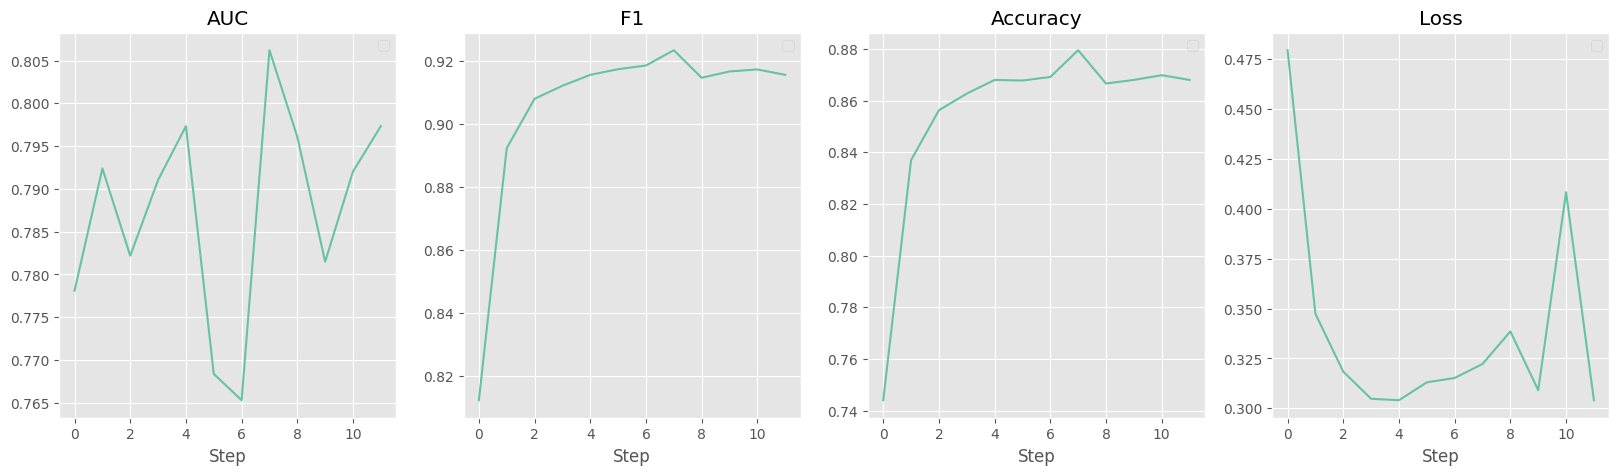

In [11]:
history = pd.DataFrame(trainer.state.log_history).dropna(subset=["eval_loss"]).set_index("step")

histories = {
    "AUC": history['eval_auc'].values,
    "F1": history['eval_f1_score'].values,
    "Accuracy": history['eval_accuracy'].values,
    "Loss": history['eval_loss'].values
}

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["AUC", "F1", "Accuracy", "Loss"]):
    ax[i].plot(histories[metric])
    ax[i].set_title(metric)
    ax[i].set_xlabel("Step")
    ax[i].legend()

plt.show()

# Making predictions and testing the model's performance

In [12]:
predictions = trainer.predict(tokenized_norec_dataset["test"])

y_test = tokenized_norec_dataset["test"]['label']
y_preds = predictions.predictions.argmax(-1)
y_probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)

In [13]:
auc = roc_auc_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

AUC: 0.8082401798300758
Accuracy: 0.876036866359447
F1 Score: 0.9209521010872759


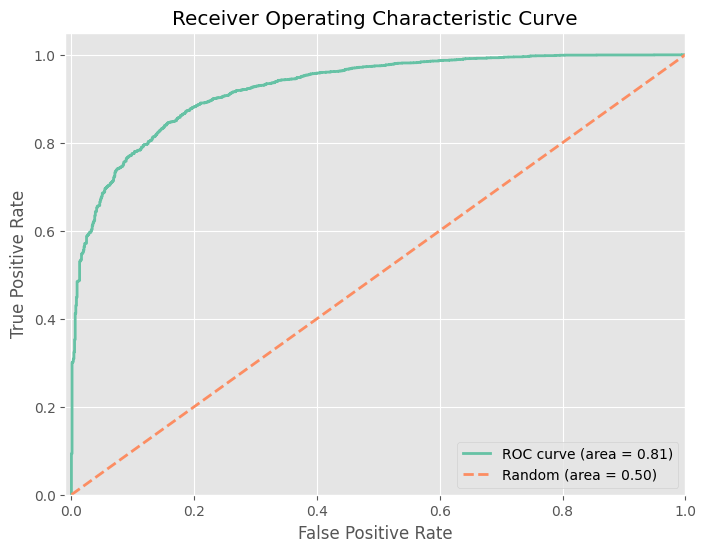

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_probs[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random (area = 0.50)')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

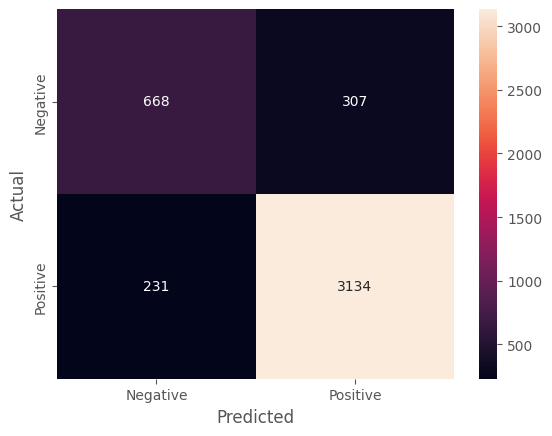

In [15]:
labels = ['Negative', 'Positive']
cm = confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()